In [53]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

In [54]:
# Manual seeding for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [55]:
# Use cuda if available else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [56]:
# Let's read user data file
user_data = pd.read_csv(
    "/home/dmitrii/vscode_projects/PMLDL/Assignment2/data/raw/ml-100k/u.data", 
    sep='\t',
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

In [57]:
class MovieDataset(Dataset):
    """
    Custom Movie Dataset. 
    """
    def __init__(self, user_ids, movie_ids, ratings):
        """
        Args:
            user_ids: ids of users
            movie_ids: ids of movies
            ratings: ratings of the corresponding movies
        """
        self.user_ids = user_ids
        self.movie_ids = movie_ids
        self.ratings = ratings

    def __len__(self):
        """
        Returns length of the dataset

        Returns:
            _type_: int
        """
        return len(self.user_ids)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): index of the required item

        Returns:
            _type_: dict
            user_ids: ids of the users
            movie_ids: ids of the movies
            ratings: ratings of the corresponding movies
        """
        sample = {
            "user_ids": torch.tensor(self.user_ids[idx], dtype=torch.long),
            "movie_ids": torch.tensor(self.movie_ids[idx], dtype=torch.long),
            "ratings": torch.tensor(self.ratings[idx], dtype=torch.float32)
        }
        return sample

In [58]:
class RecommendationModel(nn.Module):
    def __init__(self, n_users, n_movies):
        """
        Args:
            n_users (int): number of unique users
            n_movies (int): number of unique movies
        """
        super().__init__()

        self.user_embed = nn.Embedding(n_users, 96)
        self.movie_embed = nn.Embedding(n_movies, 64)

        self.fc1 = nn.Linear(160, 32)
        self.drop1 = nn.Dropout(p=0.5)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.drop2 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)


    def forward(self, users, movies):
        """
        Forward function

        Args:
            users (torch.Tensor): ids of users
            movies (torch.Tensor): ids of movies

        Returns:
            float: rating of the input movie
        """

        # Embedding of user id
        user_id_embeds = self.user_embed(users)
        # Embedding of movie id
        movie_id_embeds = self.movie_embed(movies)

        x = torch.cat([user_id_embeds, movie_id_embeds], dim=1)

        x = self.fc1(x)
        x = self.drop1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

In [59]:
label_encoder_user = preprocessing.LabelEncoder()
label_encoder_movie = preprocessing.LabelEncoder()

user_data.user_id = label_encoder_user.fit_transform(user_data.user_id.values)
user_data.movie_id = label_encoder_movie.fit_transform(user_data.movie_id.values)

In [60]:
# Let's split dataset into train and validation sets
train_split, val_split = model_selection.train_test_split(
    user_data, test_size=0.2, random_state=42, stratify=user_data.rating.values
)

# Let's create train dataset
train_dataset = MovieDataset(
    user_ids=train_split.user_id.values,
    movie_ids=train_split.movie_id.values,
    ratings=train_split.rating.values,
)

# Creating valid dataset
valid_dataset = MovieDataset(
    user_ids=val_split.user_id.values,
    movie_ids=val_split.movie_id.values,
    ratings=val_split.rating.values,
)

In [61]:
# Creating train dataloader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

# Creating valid dataloader
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

In [62]:
# Neural network
model = RecommendationModel(
    n_users=len(label_encoder_user.classes_),
    n_movies=len(label_encoder_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
loss_func = nn.MSELoss()

#### Run the training loop

In [63]:
from tqdm import tqdm

epochs = 20
total_loss = 0

train_loss_list = []
valid_loss_list = []

model.train()
for epoch in range(epochs):
    train_running_loss = 0
    for train_data in tqdm(train_loader):
        output = model(
            train_data["user_ids"].to(device),
            train_data["movie_ids"].to(device)
                      )

        rating = train_data["ratings"].view(64, -1).to(torch.float32).to(device)

        loss = torch.sqrt(loss_func(output, rating))
        train_running_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    valid_running_loss = 0
    for valid_data in tqdm(valid_loader):
        output = model(
            valid_data["user_ids"].to(device),
            valid_data["movie_ids"].to(device)
                      )
        rating = valid_data["ratings"].view(64, -1).to(torch.float32).to(device)
        loss = torch.sqrt(loss_func(output, rating))
        valid_running_loss += loss.sum().item()

    train_loss_list.append(train_running_loss/len(train_loader))
    valid_loss_list.append(valid_running_loss/len(valid_loader))

    print(f"Epoch {epoch+1} RMSE Train: {train_running_loss/len(train_loader)}")
    print(f"Epoch {epoch+1} RMSE Val: {valid_running_loss/len(valid_loader)}")

100%|██████████| 312/312 [00:00<00:00, 356.18it/s]


Epoch 1 RMSE Train: 1.5318642087459564
Epoch 1 RMSE Val: 1.070208604901265


100%|██████████| 312/312 [00:00<00:00, 480.79it/s]


Epoch 2 RMSE Train: 1.0072280592441558
Epoch 2 RMSE Val: 0.9901260634263357


100%|██████████| 312/312 [00:00<00:00, 545.79it/s]


Epoch 3 RMSE Train: 0.955708218383789
Epoch 3 RMSE Val: 0.9688828795766219


100%|██████████| 312/312 [00:00<00:00, 539.15it/s]


Epoch 4 RMSE Train: 0.9319902201175689
Epoch 4 RMSE Val: 0.9642722148161668


100%|██████████| 312/312 [00:00<00:00, 536.67it/s]


Epoch 5 RMSE Train: 0.9166558945655823
Epoch 5 RMSE Val: 0.9565307473142942


100%|██████████| 312/312 [00:00<00:00, 574.16it/s]


Epoch 6 RMSE Train: 0.9048724679946899
Epoch 6 RMSE Val: 0.9544396324035449


100%|██████████| 312/312 [00:00<00:00, 521.85it/s]


Epoch 7 RMSE Train: 0.8953327021121978
Epoch 7 RMSE Val: 0.952985080006795


100%|██████████| 312/312 [00:00<00:00, 509.99it/s]


Epoch 8 RMSE Train: 0.885996581029892
Epoch 8 RMSE Val: 0.9593175605703623


100%|██████████| 312/312 [00:00<00:00, 476.02it/s]


Epoch 9 RMSE Train: 0.8760490271568299
Epoch 9 RMSE Val: 0.9607482388233527


100%|██████████| 312/312 [00:00<00:00, 505.76it/s]


Epoch 10 RMSE Train: 0.8662428910732269
Epoch 10 RMSE Val: 0.9640330288272637


100%|██████████| 312/312 [00:00<00:00, 482.03it/s]


Epoch 11 RMSE Train: 0.8564667863845825
Epoch 11 RMSE Val: 0.9761188162060884


100%|██████████| 312/312 [00:00<00:00, 544.46it/s]


Epoch 12 RMSE Train: 0.8449373782634735
Epoch 12 RMSE Val: 0.9673946224726163


100%|██████████| 312/312 [00:00<00:00, 542.22it/s]


Epoch 13 RMSE Train: 0.8332579209327697
Epoch 13 RMSE Val: 0.9750507747133573


100%|██████████| 312/312 [00:00<00:00, 406.91it/s]


Epoch 14 RMSE Train: 0.8227354382514953
Epoch 14 RMSE Val: 0.9793020320626405


100%|██████████| 312/312 [00:00<00:00, 502.00it/s]


Epoch 15 RMSE Train: 0.8102211710929871
Epoch 15 RMSE Val: 0.9815093777500666


100%|██████████| 312/312 [00:00<00:00, 522.76it/s]


Epoch 16 RMSE Train: 0.7990138168334961
Epoch 16 RMSE Val: 0.9862049392018563


100%|██████████| 312/312 [00:00<00:00, 526.87it/s]


Epoch 17 RMSE Train: 0.7878996665000916
Epoch 17 RMSE Val: 0.9931362303785789


100%|██████████| 312/312 [00:00<00:00, 516.49it/s]


Epoch 18 RMSE Train: 0.7760673591613769
Epoch 18 RMSE Val: 1.0016297719035394


100%|██████████| 312/312 [00:00<00:00, 523.12it/s]


Epoch 19 RMSE Train: 0.7652736729621887
Epoch 19 RMSE Val: 1.015585611263911


100%|██████████| 312/312 [00:00<00:00, 414.85it/s]

Epoch 20 RMSE Train: 0.7546575122356415
Epoch 20 RMSE Val: 1.0151414506328411


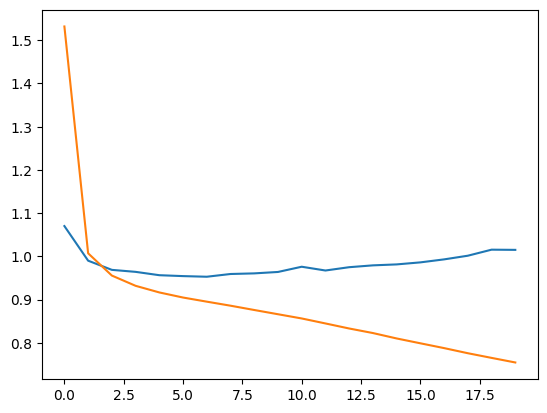

In [64]:
plt.figure()
plt.plot(valid_loss_list)
plt.plot(train_loss_list)
plt.show()

In [65]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
    for i, batched_data in enumerate(valid_loader):
        user_ids = batched_data['user_ids']
        movie_ids = batched_data['movie_ids']
        ratings = batched_data['ratings']

        model_output = model(batched_data['user_ids'].to(device), 
                             batched_data["movie_ids"].to(device))

        for i in range(len(user_ids)):
            user_id = user_ids[i].item()
            movie_id = movie_ids[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            user_est_true[user_id].append((pred_rating, true_rating))


In [68]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k = 10
    threshold = 3.5

    for user_id, rating in user_est_true.items():

        # Sort user ratings by estimated value.
        rating.sort(key=lambda x: x[0], reverse=True)

        # get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in rating)

        #  get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in rating[:k])

        # get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in rating[:k]
        )

        print(f"uid {user_id},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 342,  n_rel 32, n_rec_k 10, n_rel_and_rec_k 10
uid 832,  n_rel 20, n_rec_k 10, n_rel_and_rec_k 4
uid 238,  n_rel 22, n_rec_k 10, n_rel_and_rec_k 9
uid 237,  n_rel 4, n_rec_k 4, n_rel_and_rec_k 2
uid 197,  n_rel 12, n_rec_k 8, n_rel_and_rec_k 6
uid 668,  n_rel 10, n_rec_k 9, n_rel_and_rec_k 4
uid 499,  n_rel 27, n_rec_k 10, n_rel_and_rec_k 9
uid 541,  n_rel 11, n_rec_k 10, n_rel_and_rec_k 5
uid 233,  n_rel 34, n_rec_k 10, n_rel_and_rec_k 8
uid 560,  n_rel 24, n_rec_k 10, n_rel_and_rec_k 7
uid 42,  n_rel 27, n_rec_k 10, n_rel_and_rec_k 8
uid 193,  n_rel 22, n_rec_k 10, n_rel_and_rec_k 8
uid 22,  n_rel 22, n_rec_k 10, n_rel_and_rec_k 9
uid 86,  n_rel 18, n_rec_k 10, n_rel_and_rec_k 10
uid 346,  n_rel 21, n_rec_k 10, n_rel_and_rec_k 8
uid 889,  n_rel 12, n_rec_k 10, n_rel_and_rec_k 9
uid 164,  n_rel 8, n_rec_k 6, n_rel_and_rec_k 4
uid 100,  n_rel 2, n_rec_k 5, n_rel_and_rec_k 1
uid 879,  n_rel 39, n_rec_k 10, n_rel_and_rec_k 10
uid 529,  n_rel 7, n_rec_k 5, n_rel_and_rec_k 5
uid 567,  

In [69]:
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.670766634684981
recall @ 10 : 0.5315728810504303
